# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

import warnings
warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

# convert string of unknown data into a list
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')

# replace unknown data with nan
for i in range(len(feat_info)):
    for j in range(len(feat_info['missing_or_unknown'][i])):
        if feat_info['missing_or_unknown'][i][j] not in ['','X','XX']:
            feat_info['missing_or_unknown'][i][j] = int(feat_info['missing_or_unknown'][i][j])
    azdias.loc[:, feat_info['attribute'][i]].replace(feat_info['missing_or_unknown'][i], np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
na_count = azdias.isnull().sum()
na_percent = np.round(na_count * 100 / azdias.shape[0], 2)
colnames = na_count.index

data_tuples = list(zip(colnames, na_count, na_percent))
df_nan_col = pd.DataFrame(data_tuples, columns=['attribute','na_count', 'na_percent'], index=na_count.index)
df_nan_col.sort_values(by='na_count', ascending=False, inplace=True)

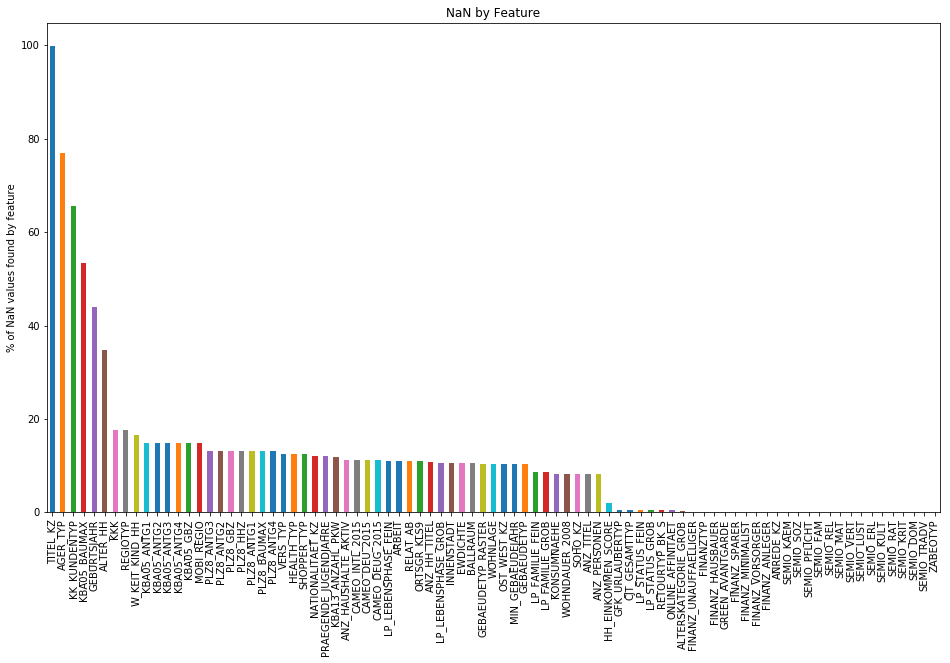

In [10]:
# Investigate patterns in the amount of missing data in each column.
df_nan_col.na_percent.plot.bar(figsize=(16, 9))
plt.title('NaN by Feature')
plt.ylabel('% of NaN values found by feature')
plt.show()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
dropcolnames = df_nan_col[df_nan_col.na_percent > 25].index.tolist()
dropcolnames

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [12]:
azdias_dropcols = azdias.drop(dropcolnames, axis=1)
azdias_dropcols.shape

(891221, 79)

In [13]:
# For the remaining features, are there any patterns in which columns have, or share, missing data?
df_nan_dropcols = df_nan_col.drop(dropcolnames, axis=0)
feat_info_dropcols = df_nan_dropcols.reset_index().merge(feat_info, how='left').set_index('index')
feat_info_dropcols.shape

(79, 6)

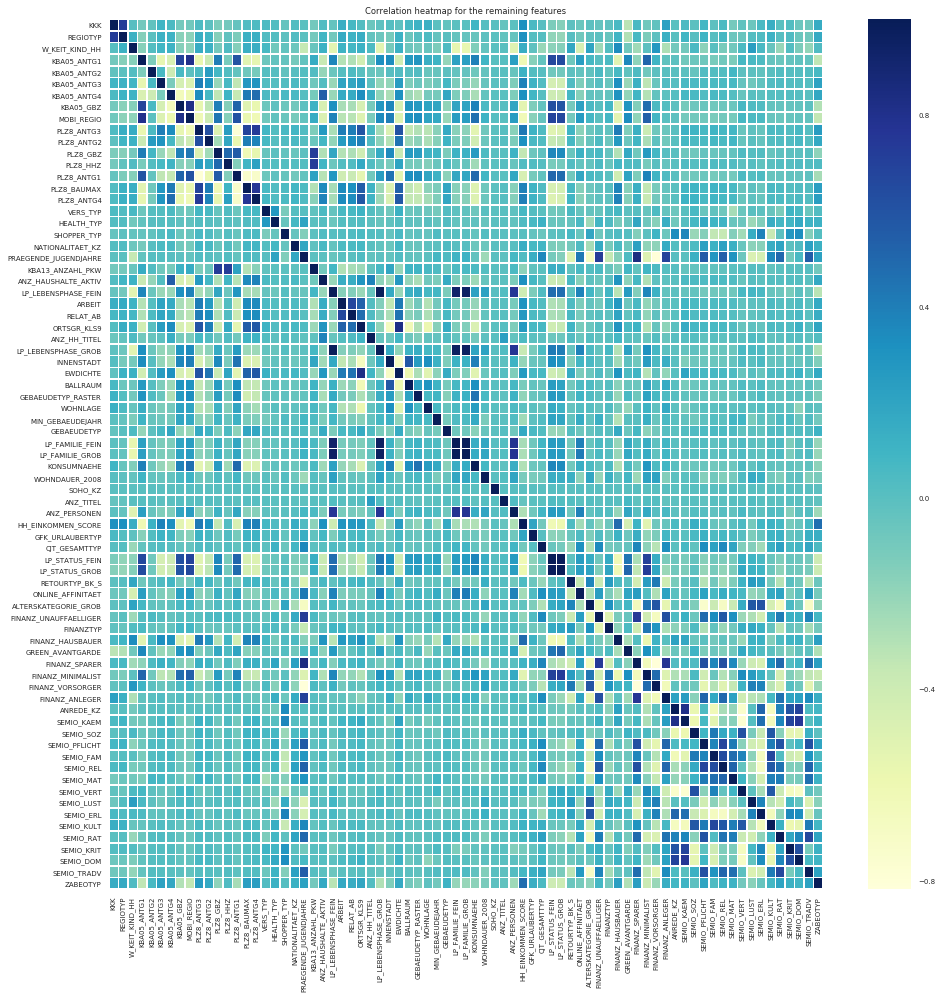

In [14]:
features_sel = feat_info_dropcols['attribute']
data_explore = azdias.loc[:,features_sel]

plt.figure(figsize=(16,16))
sns.set(font_scale=0.7)
hmap = sns.heatmap(data_explore.corr(), cmap="YlGnBu",linewidths=.5,xticklabels=True, yticklabels=True)
plt.title('Correlation heatmap for the remaining features')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

Based on the 'NaN by Feature' bar plot above, there are some columns which seem to have a higher proportion of missing data in comparison to the rest. Although it may sound a bit arbitrary, I decided to exclude any column with more than 25% of mising data. I am not sure what would be a reasonable cut-off value to drop a column but by looking at the bar plot it seems that the proportion of NaN values in each column starts to decrease slowly after the ALTER_HH feature (which has 34.81% of missing values). This means that any cut-off value below the NaN proportion of the following feature -named KKK- could result in a significan amount of columns being dropped - which is not a desired situation since we could be losing lots of information. Having said this, I decided to come up with a 25% cut-off value which is somewhere in between the ALTER_HH and the KKK proportions of NaN.

In addition, I investigated the correlation for the remaining features by plotting a correlation heatmap. Potentially, I could drop some additional features which have a high proportion of NaN values and which are highly correlated with other features that have no NaN values or a lower proportion of them. We could argue that those features would not provide additional value when it comes to perform the clustering analysis since there are other features with more complete data providing similar information. So, removing those correlated features with high missing data may improve our clustering goal by getting rid of noisy data. Unfortunately, it seems that those features that are correlated to each other have typically a very similar amount of missing values. So, I am not convinced that we will benefit that much from dropping additional columns just because they present high correlation. In addition, since I will be applying the PCA before the clustering, I would expect for the PCA to take care of assigning low weights to those features which are highly correlated to others. So, at this stage, I would prefer not to drop any additional features.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
na_countperrow = azdias_dropcols.isnull().sum(axis=1)
row_per = sum(na_countperrow.lt(1))/len(na_countperrow)
print('{:.2%}' .format(row_per) + ' of the rows have no missing values.')

69.93% of the rows have no missing values.


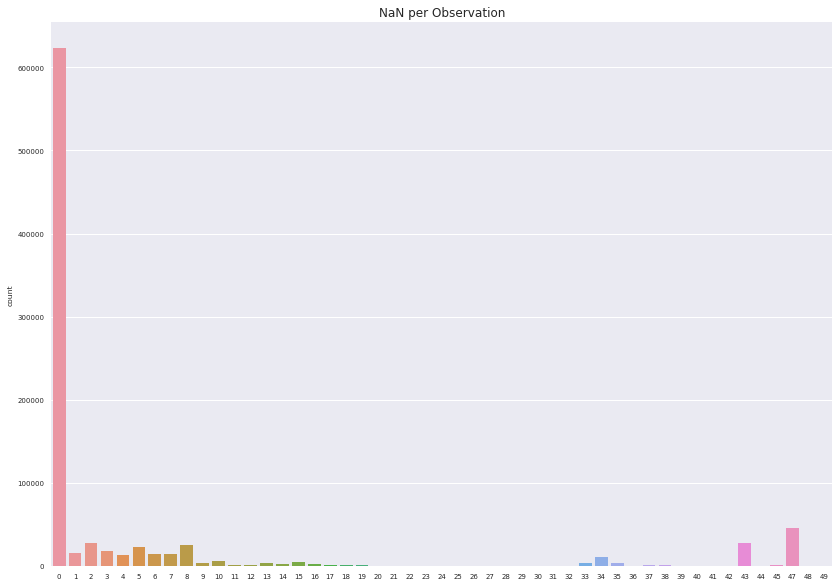

In [16]:
plt.figure(figsize=(14,10))
sns.countplot(na_countperrow)
sns.set(font_scale=1)
plt.title('NaN per Observation')
plt.show()

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
split_value = 20
data_reduced = azdias_dropcols[na_countperrow < split_value]
data_nan = azdias_dropcols[na_countperrow >= split_value]

In [18]:
# confirm the split is correct by checking the total number of rows on both dataframes
len(data_reduced)+len(data_nan)

891221

In [19]:
# Porportion of rows with a few or no missing values (<20 NaN per row)
lowna_row_per = len(data_reduced)/len(azdias_dropcols)
print('{:.2%}' .format(lowna_row_per) + ' of the rows have a few or no missing values.')

89.44% of the rows have a few or no missing values.


In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_feature_dist(col_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
    ax1.title.set_text('Histogram from data with few missing values')
    sns.countplot(data_reduced.loc[:,col_name], ax = ax1)
    ax2.title.set_text('Histogram from data with high missing values')
    sns.countplot(data_nan.loc[:,col_name], ax = ax2)

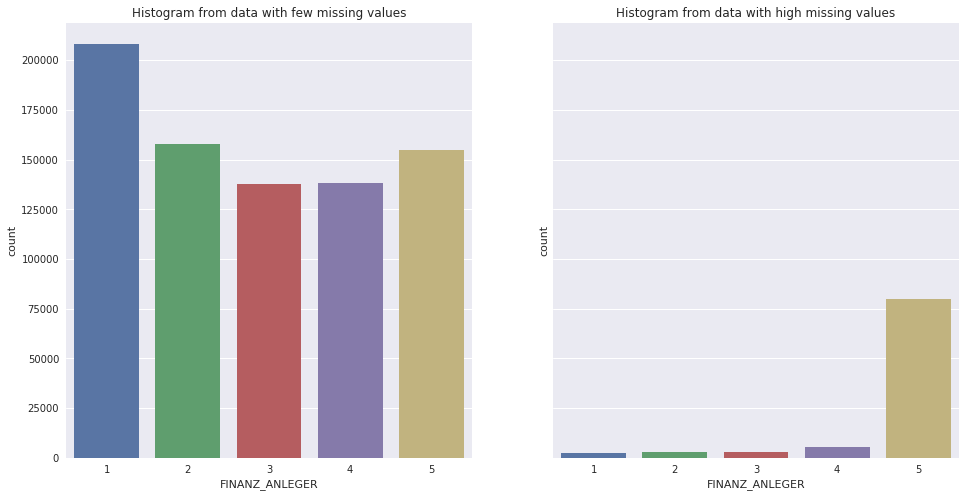

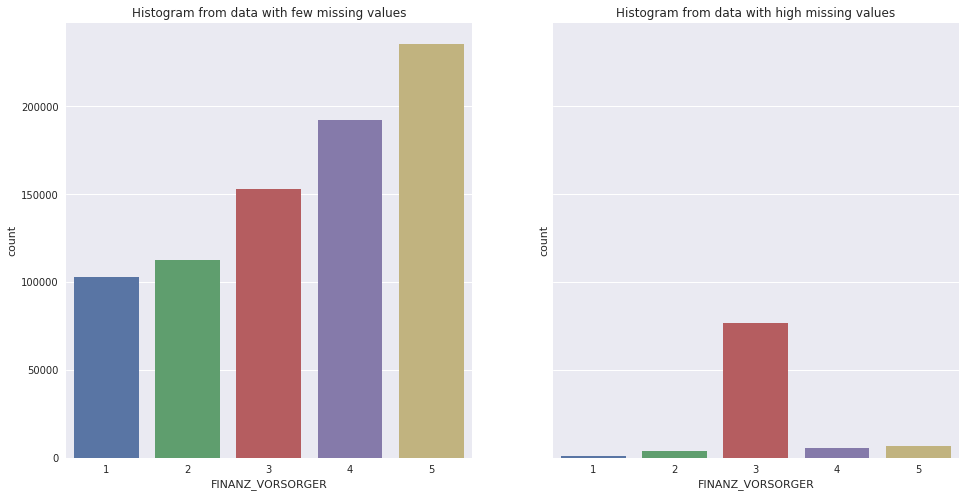

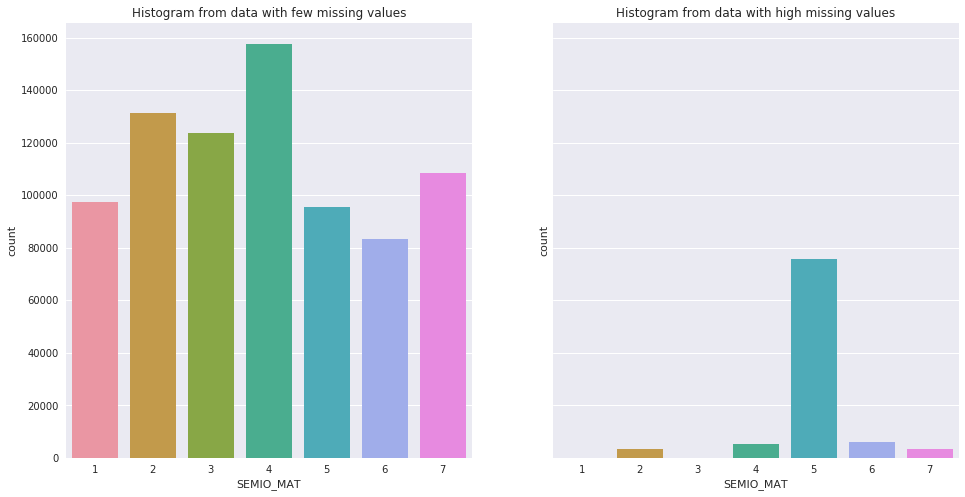

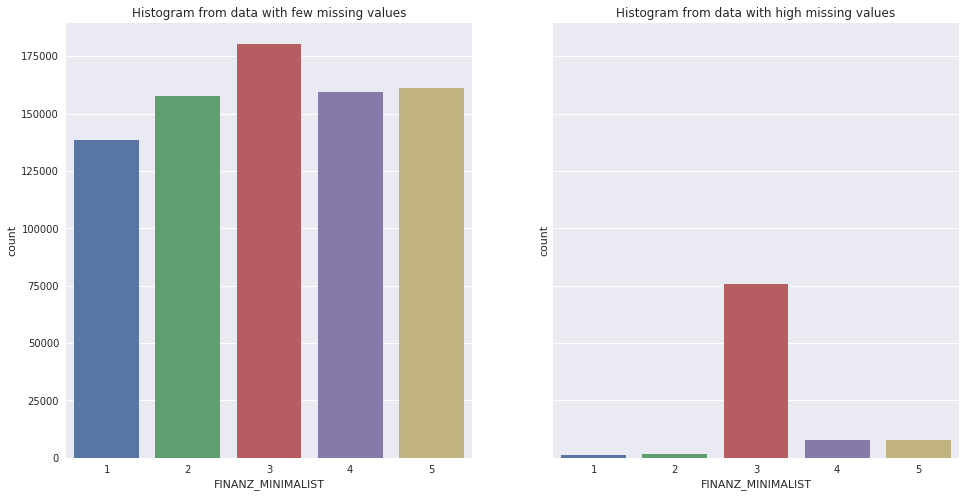

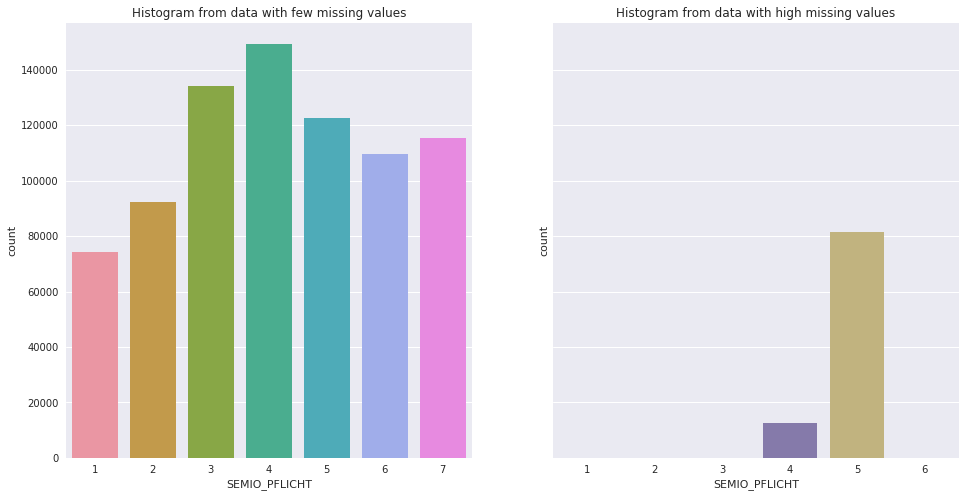

In [21]:
# Only compare features with no missing data
sample_cols = azdias_dropcols.columns[azdias_dropcols.notnull().all()].to_series().sample(5)

for col in sample_cols:
    plot_feature_dist(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)  

Approximately 70% of the rows have no missing values at all. Now, by looking at the bar plot titled 'NaN Per Observation' it seems that there are a few amount of rows with clearly a higher proportion of missing values compared to the rest (the tail of the plot). Having said this, I decided to use a threshold of 20 missing values per row to split the original dataset into two new subsets. This means that ~89% of the records having a few or no missing values per row are now captured on the data_reduced dataframe while the remaining ~11% of the data having a high proportion of missing values per row are stored on the data_nan dataframe.

When comparing the distributions of five "non-missing" features between the subset of data with high missing values against the other subset of data with a few missing values, I can see that these do not look similar. This means that by leaving behind those rows with a higher number of NaN values I am also potentially loosing some valuable information on some of the "non-missing" features. Since it is suggested that I continue with the subset of data with a few missing values then I will revisit this later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
feat_info_dropcols.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info_dropcols[feat_info_dropcols['type'] == 'categorical']['attribute'].values
data_reduced[categorical].nunique()

VERS_TYP             2
SHOPPER_TYP          4
NATIONALITAET_KZ     3
CAMEO_DEU_2015      44
CAMEO_DEUG_2015      9
OST_WEST_KZ          2
GEBAEUDETYP          7
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
SOHO_KZ              2
GFK_URLAUBERTYP     12
CJT_GESAMTTYP        6
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
FINANZTYP            6
GREEN_AVANTGARDE     2
ANREDE_KZ            2
ZABEOTYP             6
dtype: int64

In [24]:
binary = [x for x in categorical if data_reduced[x].nunique()==2]
multilevel = [x for x in categorical if data_reduced[x].nunique()>2]

In [25]:
# Identify binary feature with non-numeric values
for col in binary:
    print(data_reduced[col].value_counts())

2.0    394116
1.0    366623
Name: VERS_TYP, dtype: int64
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
2    415578
1    381499
Name: ANREDE_KZ, dtype: int64


In [26]:
data_reduced.shape

(797077, 79)

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
data_reduced.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
data_reduced = pd.get_dummies(data_reduced, columns=multilevel)

In [28]:
data_reduced.shape

(797077, 194)

In [29]:
# Print the number of features after one-hot encoding
encoded = list(data_reduced.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

194 total features after one-hot encoding.


In [30]:
# Print encoded feature names
print(encoded)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

As suggested, I re-encoded the binary variable OST_WEST_KZ which had non-numeric values to distinguish between East and West Germany. The rest of the binary variables remained unchanged.

In terms of the multi-level categorical features, I decided to perform the one-hot encoding. There is one particular feature CAMEO_DEU_2015 that has many levels as it describes the wealth/life stage typology in more detail. Although doing a one-hot encoding will result in many additional features being generated I don't think this will present a major issue ('curse of dimensionality) since I will be applying the PCA later on.

I decided not to drop any additional features at this point.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
values = [x+1 for x in range(15)]
decades = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
generation = pd.Series(decades, index = values)        
        
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

def get_movement(value):
    if value in mainstream:
        return 1
    elif value in avantgarde:
        return 0
    else:
        return value

In [32]:
# Genereate 2 new features
data_reduced['PRAEGENDE_JUGENDJAHRE_GEN'] = data_reduced['PRAEGENDE_JUGENDJAHRE'].map(generation)
data_reduced['PRAEGENDE_JUGENDJAHRE_MOV'] = data_reduced['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)


In [33]:
# Quick to ensure that the conversion worked
data_reduced.loc[0:10, ('PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_GEN','PRAEGENDE_JUGENDJAHRE_MOV')]

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOV
1,14.0,90.0,1.0
2,15.0,90.0,0.0
3,8.0,70.0,1.0
4,8.0,70.0,1.0
5,3.0,50.0,1.0
6,10.0,80.0,1.0
7,8.0,70.0,1.0
8,11.0,80.0,0.0
9,15.0,90.0,0.0
10,3.0,50.0,1.0


In [34]:
# Remove the original feature 'PRAEGENDE_JUGENDJAHRE'
data_reduced = data_reduced.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
data_reduced.shape

(797077, 195)

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def get_wealth(value):
    if pd.isnull(value):
        return value
    else:
        return int(str(value)[0])

def get_lifestage(value):
    if pd.isnull(value):
        return value
    else:
        return int(str(value)[1])

In [36]:
# Genereate 2 new features
data_reduced['CAMEO_INTL_2015_WEALTH'] = data_reduced['CAMEO_INTL_2015'].apply(get_wealth)
data_reduced['CAMEO_INTL_2015_LIFESTAGE'] = data_reduced['CAMEO_INTL_2015'].apply(get_lifestage)

In [37]:
# Quick to ensure that the conversion worked
data_reduced.loc[0:10, ('CAMEO_INTL_2015','CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFESTAGE')]

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0
10,51,5.0,1.0


In [38]:
# Remove the original feature 'CAMEO_INTL_2015'
data_reduced = data_reduced.drop('CAMEO_INTL_2015', axis=1)
data_reduced.shape

(797077, 196)

In [39]:
# Update the features info dataframe to drop above original mixed features
feat_info_dropcols = feat_info_dropcols.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=0)
feat_info_dropcols.shape

(77, 6)

In [40]:
# Review remaining mixed features
mixed = feat_info_dropcols[feat_info_dropcols['type'] == 'mixed']['attribute'].values
data_reduced[mixed].nunique()

PLZ8_BAUMAX             5
LP_LEBENSPHASE_FEIN    40
LP_LEBENSPHASE_GROB    12
WOHNLAGE                8
dtype: int64

In [41]:
# Investigate PLZ8_BAUMAX - Most common building type within the PLZ8 region
# 1: mainly 1-2 family homes
# 2: mainly 3-5 family homes
# 3: mainly 6-10 family homes
# 4: mainly 10+ family homes
# 5: mainly business buildings
    
# Convert into two new binary features to simply distinguish between family type and business type

family = [1, 2, 3, 4]
building = [5]

def get_family(value):
    if pd.isnull(value):
        return value
    elif value in family:
        return 1
    else:
        return 0

def get_business(value):
    if pd.isnull(value):
        return value
    elif value in building:
        return 1
    else:
        return 0

In [42]:
# Genereate 2 new features
data_reduced['PLZ8_BAUMAX_FAMILY'] = data_reduced['PLZ8_BAUMAX'].apply(get_family)
data_reduced['PLZ8_BAUMAX_BUSINESS'] = data_reduced['PLZ8_BAUMAX'].apply(get_business)

In [43]:
# Quick check to ensure that the conversion worked
data_reduced.loc[50:60, ('PLZ8_BAUMAX','PLZ8_BAUMAX_FAMILY','PLZ8_BAUMAX_BUSINESS')]

,PLZ8_BAUMAX,PLZ8_BAUMAX_FAMILY,PLZ8_BAUMAX_BUSINESS
50,1.0,1.0,0.0
51,1.0,1.0,0.0
52,5.0,0.0,1.0
55,3.0,1.0,0.0
56,1.0,1.0,0.0
57,2.0,1.0,0.0
58,1.0,1.0,0.0
59,3.0,1.0,0.0
60,4.0,1.0,0.0


In [44]:
# Remove the original feature 'PLZ8_BAUMAX'
data_reduced = data_reduced.drop('PLZ8_BAUMAX', axis=1)
data_reduced.shape

(797077, 197)

In [45]:
# Investigate WOHNLAGE - Neighborhood quality (or rural flag)
# 0: no score calculated
# 1: very good neighborhood
# 2: good neighborhood
# 3: average neighborhood
# 4: poor neighborhood
# 5: very poor neighborhood
# 7: rural neighborhood
# 8: new building in rural neighborhood

data_reduced['WOHNLAGE'].value_counts()

3.0    249537
7.0    169238
4.0    135867
2.0    100303
5.0     74274
1.0     43876
8.0     17356
0.0      6626
Name: WOHNLAGE, dtype: int64

In [46]:
# Initial transformation steps:
# Assign 0 values to the most frequent value (average neighborhood)
# Combine 1 and 2 into a single category - 'good neighborhood'
# Combine 4 and 5 into a single category - 'poor neighborhood'
# Combine 7 and 8 into a single category - 'rural neighborhood'

data_reduced.loc[:,'WOHNLAGE'].replace({0:3, 1:2, 5:4, 8:7}, inplace=True)

# Quick check on above replacement
data_reduced['WOHNLAGE'].value_counts()

3.0    256163
4.0    210141
7.0    186594
2.0    144179
Name: WOHNLAGE, dtype: int64

In [47]:
# Finally perform one-hot encoding on the updated categories
data_reduced = pd.get_dummies(data_reduced, columns=['WOHNLAGE'])

In [48]:
# Investigate LP_LEBENSPHASE_FEIN -Life stage, fine scale 
# Life stage, fine scale
# -  1: single low-income earners of younger age
# -  2: single low-income earners of middle age
# -  3: single average earners of younger age
# -  4: single average earners of middle age
# -  5: single low-income earners of advanced age
# -  6: single low-income earners at retirement age
# -  7: single average earners of advanced age
# -  8: single average earners at retirement age
# -  9: single independent persons
# - 10: wealthy single homeowners
# - 11: single homeowners of advanced age
# - 12: single homeowners at retirement age
# - 13: single top earners of higher age
# - 14: low-income and average earner couples of younger age
# - 15: low-income earner couples of higher age
# - 16: average earner couples of higher age
# - 17: independent couples
# - 18: wealthy homeowner couples of younger age
# - 19: homeowner couples of higher age
# - 20: top earner couples of higher age
# - 21: single parent low-income earners
# - 22: single parent average earners
# - 23: single parent high-income earners
# - 24: low-income earner families
# - 25: average earner families
# - 26: independent families
# - 27: homeowner families
# - 28: top earner families
# - 29: low-income earners of younger age from multiperson households
# - 30: average earners of younger age from multiperson households
# - 31: low-income earners of higher age from multiperson households
# - 32: average earners of higher age from multiperson households
# - 33: independent persons of younger age from multiperson households
# - 34: homeowners of younger age from multiperson households
# - 35: top earners of younger age from multiperson households
# - 36: independent persons of higher age from multiperson households
# - 37: homeowners of advanced age from multiperson households
# - 38: homeowners at retirement age from multiperson households
# - 39: top earners of middle age from multiperson households
# - 40: top earners at retirement age from multiperson households
    
data_reduced['LP_LEBENSPHASE_FEIN'].value_counts()

1.0     58718
5.0     52399
6.0     43324
2.0     37146
8.0     28831
11.0    25356
7.0     24947
29.0    24879
13.0    24810
10.0    24458
31.0    22260
12.0    22214
30.0    21145
15.0    18963
3.0     18752
19.0    18575
37.0    17500
4.0     16477
14.0    16350
20.0    16285
32.0    15761
39.0    15131
40.0    14108
27.0    13795
16.0    13632
38.0    13088
35.0    13011
34.0    12421
9.0     12109
21.0    11965
28.0    11543
24.0    11308
25.0     9843
36.0     9654
23.0     8624
22.0     6830
18.0     6802
33.0     5722
17.0     5486
26.0     3368
Name: LP_LEBENSPHASE_FEIN, dtype: int64

In [49]:
# Investigate LP_LEBENSPHASE_GROB - Life stage, rough scale
# Life stage, rough scale
# -  1: single low-income and average earners of younger age
# -  2: single low-income and average earners of higher age
# -  3: single high-income earners
# -  4: single low-income and average-earner couples
# -  5: single high-income earner couples
# -  6: single parents
# -  7: single low-income and average earner families
# -  8: high-income earner families
# -  9: average earners of younger age from multiperson households
# - 10: low-income and average earners of higher age from multiperson households
# - 11: high-income earners of younger age from multiperson households
# - 12: high-income earners of higher age from multiperson households

data_reduced['LP_LEBENSPHASE_GROB'].value_counts()

2.0     149501
1.0     131093
3.0     109528
12.0     69481
4.0      51172
5.0      47148
9.0      46024
10.0     38021
11.0     31154
8.0      28706
6.0      27419
7.0      21151
Name: LP_LEBENSPHASE_GROB, dtype: int64

In [50]:
# The categories under each of the above two features LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB are quite specific.
# It is difficult to perform any grouping.
# Since these 2 features are highly correlated, I will drop the one with higher number of categories and keep the other one
# for one-hot encoding.

# Drop LP_LEBENSPHASE_FEIN
data_reduced = data_reduced.drop('LP_LEBENSPHASE_FEIN', axis=1)

# One-hot encode LP_LEBENSPHASE_GROB
data_reduced = pd.get_dummies(data_reduced, columns=['LP_LEBENSPHASE_GROB'])

In [51]:
# Update the features info dataframe to drop above original mixed feature
feat_info_dropcols = feat_info_dropcols.drop(['LP_LEBENSPHASE_FEIN'], axis=0)
feat_info_dropcols.shape

(76, 6)

In [52]:
# Print the number of features after one-hot encoding
encoded = list(data_reduced.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

210 total features after one-hot encoding.


In [53]:
# Print encoded feature names
print(encoded)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0', 'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

As suggested on the project, I performed the transformations to the features named PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. These features had a clear way of separating its mixed values in order to get new features.

The next mixed feature I analized was PLZ8_BAUMAX - which refers to the most common building type within the PLZ8 region. On this feature, we can make a distinction between family and business building types. Although we will lose visiblity on the size of the family buildings, we can still make use of some of the information contained on this feature. Two new binary variables were created.

The other feature considered was WOHNLAGE - which refers to the quality of the neighborhood (or rural flag). If we look at the frequency per category value, it seems reasonable to group some of these values and then perform a one-hot encoding to create new binary variables. I decided to group some categories because they had very low frequency and if I would create a binary variable out of those then I would end up with a feature having mainly 0's and a few 1's - which is not going to help that much for clustering or any sort of analyses. So, the following categories were grouped together before one-hot encoding: "good and very good", "poor and very poor", and finally "rural and new building in rural neighborhood". Also, I replaced the 'no score calculated' with the most frequent category (average neighborhood).

Finally, I examined the LP_LEBENSPHASE_FEIN -life stage, fine scale- and LP_LEBENSPHASE_GROB -life stage, rough scale. The categories under these two features are quite specific and it is hard to perform any grouping or transformation into them. Having said this, I decided to perform a one-hot encoding transformation. Since these features are highly correlated (see correlation heatmap plotted in previous section), it makes sense to drop the feature with the higher number of categories and just keep the other one. This will avoid increasing the number of freatures in our data set unnecessarily after doing the one-hot encoding.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [54]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    # convert string of unknown data into a list
    feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')

    # replace unknown data with nan
    for i in range(len(feat_info)):
        for j in range(len(feat_info['missing_or_unknown'][i])):
            if feat_info['missing_or_unknown'][i][j] not in ['','X','XX']:
                feat_info['missing_or_unknown'][i][j] = int(feat_info['missing_or_unknown'][i][j])
        df.loc[:, feat_info['attribute'][i]].replace(feat_info['missing_or_unknown'][i], np.nan, inplace=True)
    
    # Remove columns based on analysis previously done (more than %25 of NaNs)
    df_dropcols = df.drop(dropcolnames, axis=1)
    
    df_nan_dropcols = df_nan_col.drop(dropcolnames, axis=0)
    feat_info_dropcols = df_nan_dropcols.reset_index().merge(feat_info, how='left').set_index('index')
    
    # Remove any rows with high proportion of NaNs per row
    na_countperrow = df_dropcols.isnull().sum(axis=1)
    data_reduced = df_dropcols[na_countperrow < split_value]
    
    # Re-encode categorical features
    categorical = feat_info_dropcols[feat_info_dropcols['type'] == 'categorical']['attribute'].values
    multilevel = [x for x in categorical if data_reduced[x].nunique()>2]
    data_reduced = pd.get_dummies(data_reduced, columns=multilevel)
    
    # Re-encode OST_WEST_KZ
    data_reduced.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
    
    # Re-encode PRAEGENDE_JUGENDJAHRE
    values = [x+1 for x in range(15)]
    decades = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    generation = pd.Series(decades, index = values)   

    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    def get_movement(value):
        if value in mainstream:
            return 1
        elif value in avantgarde:
            return 0
        else:
            return value
    
    data_reduced['PRAEGENDE_JUGENDJAHRE_GEN'] = data_reduced['PRAEGENDE_JUGENDJAHRE'].map(generation)
    data_reduced['PRAEGENDE_JUGENDJAHRE_MOV'] = data_reduced['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)
    data_reduced = data_reduced.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Re-encode CAMEO_INTL_2015
    def get_wealth(value):
        if pd.isnull(value):
            return value
        else:
            return int(str(value)[0])

    def get_lifestage(value):
        if pd.isnull(value):
            return value
        else:
            return int(str(value)[1])
    
    data_reduced['CAMEO_INTL_2015_WEALTH'] = data_reduced['CAMEO_INTL_2015'].apply(get_wealth)
    data_reduced['CAMEO_INTL_2015_LIFESTAGE'] = data_reduced['CAMEO_INTL_2015'].apply(get_lifestage)
    data_reduced = data_reduced.drop('CAMEO_INTL_2015', axis=1)
    
    # Re-encode PLZ8_BAUMAX
    family = [1, 2, 3, 4]
    building = [5]

    def get_family(value):
        if pd.isnull(value):
            return value
        elif value in family:
            return 1
        else:
            return 0

    def get_business(value):
        if pd.isnull(value):
            return value
        elif value in building:
            return 1
        else:
            return 0
    
    data_reduced['PLZ8_BAUMAX_FAMILY'] = data_reduced['PLZ8_BAUMAX'].apply(get_family)
    data_reduced['PLZ8_BAUMAX_BUSINESS'] = data_reduced['PLZ8_BAUMAX'].apply(get_business)
    data_reduced = data_reduced.drop('PLZ8_BAUMAX', axis=1)
    
    # Re-encode WOHNLAGE
    data_reduced.loc[:,'WOHNLAGE'].replace({0:3, 1:2, 5:4, 8:7}, inplace=True)
    data_reduced = pd.get_dummies(data_reduced, columns=['WOHNLAGE'])
    
    # Drop LP_LEBENSPHASE_FEIN
    data_reduced = data_reduced.drop('LP_LEBENSPHASE_FEIN', axis=1)

    # Re-encode LP_LEBENSPHASE_GROB
    data_reduced = pd.get_dummies(data_reduced, columns=['LP_LEBENSPHASE_GROB'])
    
    # Drop GEBAEUDETYP_5.0 if generated before since this is not present on the customers dataset
    # See "Discussion Point" added below
    if 'GEBAEUDETYP_5.0' in data_reduced:
        data_reduced = data_reduced.drop('GEBAEUDETYP_5.0', axis=1)
    
    return data_reduced

In [55]:
# Apply the clean_data function
df = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
azdias_clean_data = clean_data(df)

In [56]:
# Quick check to confirm the clean_data function is giving the correct shape
azdias_clean_data.shape

(797077, 209)

In [57]:
# Quick check to confirm the clean_data function is giving the correct shape
data_reduced.shape

(797077, 210)

In [58]:
azdias_clean_data.isnull().values.any()

True

__Discussion Point:__  

By the time I reached the point when I had to apply the above clean_data() function into the customers dataset, I noticed that the shape of the resulting customer dataframe was (115643, 209). However, I was expecting for the customers cleaned dataset to have 210 features, i.e. the same number of features as in the azdias demographics dataset.

After doing some investigation, I realized that this occurred because the azdias and the customers datasets don't have the same unique values for all the categorical variables. In particular, the customers dataset doesn't have a value of 5 under the GEBAEUDETYP feature - which is used to identify company buildings. This was the reason why the customers dataset had 1 less feature. 

Having said this, I decided to drop this dummy feature as it doesn't seem that relevant. To do this, I added an additional check at the end of the data_clean() function. This also explains why the shape of the data_reduced dataframe has 1 extra feature in compared to the azdias_clean_data shape resulting from the clean_data() function.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer()
azdias_clean_data = pd.DataFrame(imputer.fit_transform(azdias_clean_data), columns = azdias_clean_data.columns)

In [60]:
# Quick check to confirm there are no missing values
azdias_clean_data.isnull().values.any()

False

In [61]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled_data = scaler.fit_transform(azdias_clean_data)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I decided to use the Imputer() function to replace all missing values and then to apply the StandardScaler().

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled_data)

In [63]:
# Investigate the variance accounted for by each principal component.
# Below code was adapted from the lessons

def scree_plot(pca, comp=None, show_labels=False):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
#     num_components=len(pca.explained_variance_ratio_)
#     ind = np.arange(num_components)
#     vals = pca.explained_variance_ratio_
    
    if comp: 
        num_components=comp
        ind = np.arange(num_components)
        vals = pca.explained_variance_ratio_[:num_components]
    else:
        num_components=len(pca.explained_variance_ratio_)
        ind = np.arange(num_components)
        vals = pca.explained_variance_ratio_       
        
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.05, vals[i])
                        ,va="bottom"
                        ,ha="center"
                        ,fontsize=12
                        ,rotation=90
                       )
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


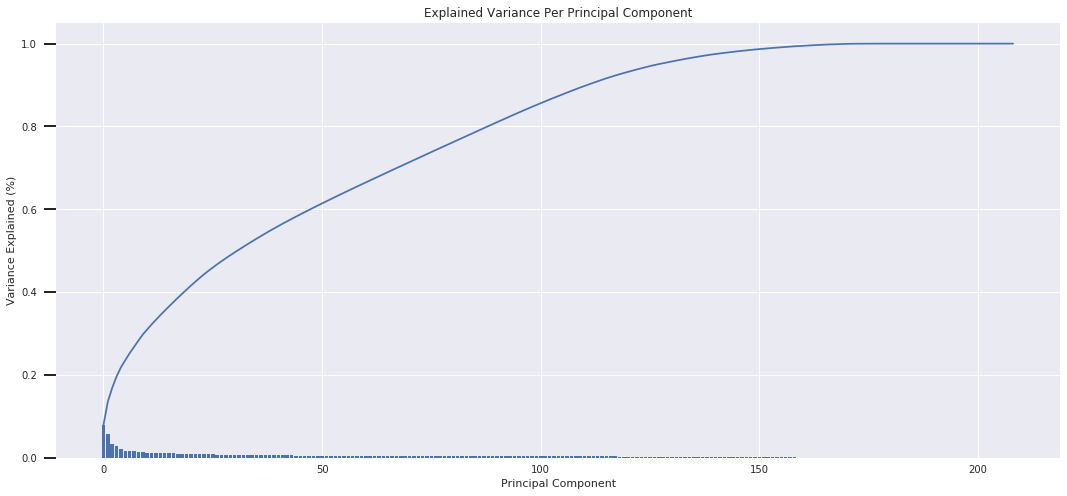

In [64]:
scree_plot(pca, show_labels=False)

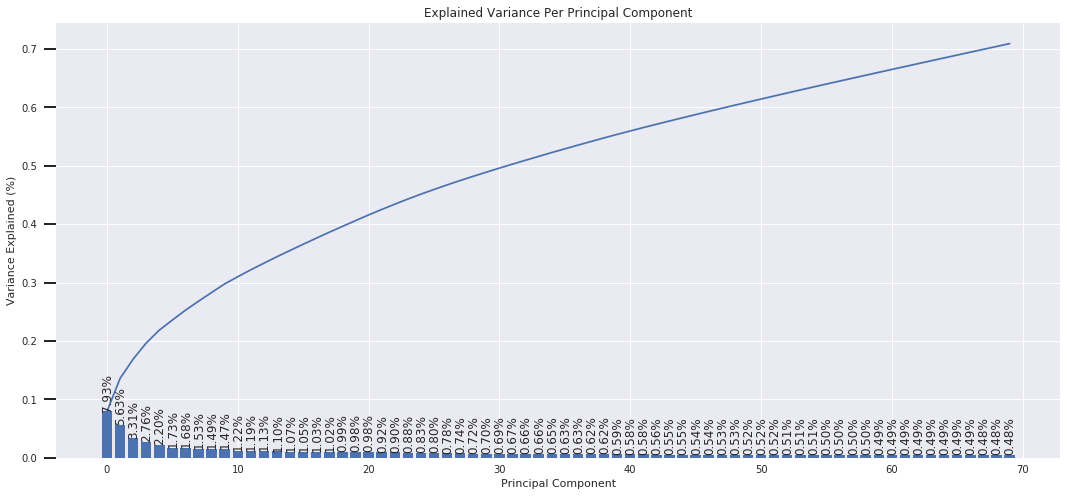

In [65]:
scree_plot(pca, comp=70, show_labels=True)

In [66]:
## Keep only those components that explained at least 0.5% of the variability on the original data
var_threshold = 0.005
num_comps = max(np.where(pca.explained_variance_ratio_ >= var_threshold)[0]) + 1

In [67]:
# What is the total variability explained by those components?
var_explained_per = pca.explained_variance_ratio_[:num_comps-1].sum()
print('The first {} components explain {:.2%} of the total variability on the original data.' .format(num_comps, var_explained_per))

The first 59 components explain 65.01% of the total variability on the original data.


In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=num_comps)
azdias_pca = pca.fit_transform(azdias_scaled_data)

In [69]:
# Quick check on the new pca
pca.components_.shape

(59, 209)

In [70]:
print('{:.2%} of the total variability explained.' .format(pca.explained_variance_ratio_.sum()))

64.90% of the total variability explained.


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

If we look at the scree plot we can identify a threshold after which the variability explained by each component is too small to justify keeping it. From the initial scree plot where all components were plotted, it seems that approximately after the 150th component the percentage of the cummulative variability explained is increasing at a very slow rate. This would suggest that it is not worthy to keep any more than 150 components. However, we should also notice that we still have a very long tail of components explaining a rather small percentage of the variability (less than 1%) so I would think that many of those components would not contribute that much to our clustering analysis. Having said this, I decided to choose a threshold of 0.5% on the variablilty explained by each component. This means that any component that explain or holds less than 0.5% of the original data variability will be discarded.

Based on the above approach, I decided to keep the first 59 components which explain a total of ~65% of the variability on the orginal data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Again code below was adapted from the lessons

def pca_results(data, pca, k_comp, top_k_weights):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    
    if k_comp <= len(pca.components_) and k_comp > 0 and top_k_weights <= azdias_pca.shape[1]:
       
        # PCA components
        components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[k_comp-1]
        components.sort_values(ascending=False, inplace=True)
        
        # Return a concatenated DataFrame with top_k_weights
        df = pd.concat([components.head(top_k_weights),components.tail(top_k_weights)])
        
        # PCA explained variance
        #ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)[k_comp-1]
        #variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
        #variance_ratios.index = dimensions

        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        df.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(df.index, rotation=90)    
        plt.title('Component {} explains {:.2%} of the original data variability'.format(k_comp, pca.explained_variance_ratio_[k_comp-1]))
        
        return df
    
    else:
        print('That is not the right input, please review the number of components and features.')

LP_STATUS_GROB_1.0        0.1879
HH_EINKOMMEN_SCORE        0.1772
CAMEO_INTL_2015_WEALTH    0.1772
PLZ8_ANTG3                0.1767
PLZ8_ANTG4                0.1725
ORTSGR_KLS9               0.1537
EWDICHTE                  0.1515
FINANZ_HAUSBAUER          0.1453
LP_STATUS_FEIN_1.0        0.1253
KBA05_ANTG4               0.1236
WOHNLAGE_7.0             -0.1115
PLZ8_BAUMAX_FAMILY       -0.1167
INNENSTADT               -0.1256
PLZ8_GBZ                 -0.1301
KONSUMNAEHE              -0.1341
KBA05_GBZ                -0.1750
PLZ8_ANTG1               -0.1775
FINANZ_MINIMALIST        -0.1809
KBA05_ANTG1              -0.1838
MOBI_REGIO               -0.1971
Name: 0, dtype: float64

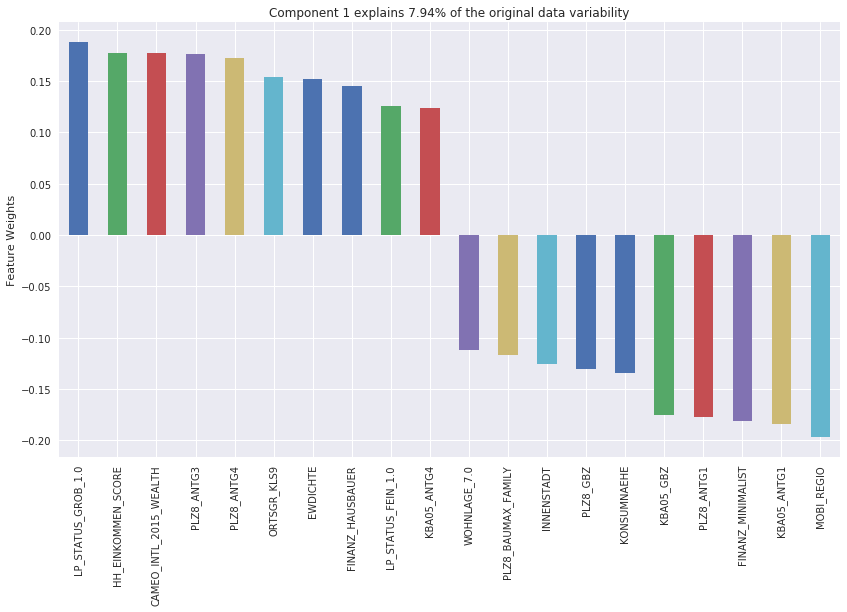

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_clean_data, pca, k_comp=1, top_k_weights=10)

ALTERSKATEGORIE_GROB         0.2281
FINANZ_VORSORGER             0.2176
ZABEOTYP_3                   0.1945
SEMIO_ERL                    0.1716
SEMIO_LUST                   0.1594
RETOURTYP_BK_S               0.1538
LP_LEBENSPHASE_GROB_2.0      0.1462
W_KEIT_KIND_HH               0.1250
CJT_GESAMTTYP_2.0            0.1054
FINANZTYP_5                  0.0976
SEMIO_KULT                  -0.1557
ONLINE_AFFINITAET           -0.1575
SEMIO_RAT                   -0.1673
SEMIO_PFLICHT               -0.2009
FINANZ_ANLEGER              -0.2024
SEMIO_TRADV                 -0.2031
SEMIO_REL                   -0.2070
FINANZ_UNAUFFAELLIGER       -0.2124
FINANZ_SPARER               -0.2263
PRAEGENDE_JUGENDJAHRE_GEN   -0.2353
Name: 1, dtype: float64

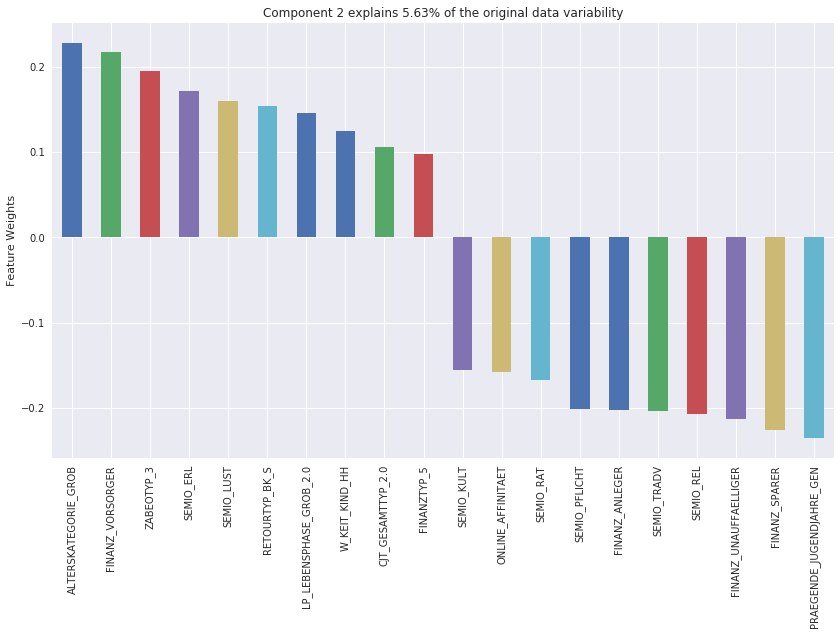

In [73]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_clean_data, pca, k_comp=2, top_k_weights=10)


SEMIO_VERT                   0.3110
SEMIO_FAM                    0.2571
SEMIO_SOZ                    0.2525
SEMIO_KULT                   0.2492
FINANZTYP_5                  0.1327
FINANZ_MINIMALIST            0.1300
ZABEOTYP_1                   0.1233
SHOPPER_TYP_0.0              0.1196
SEMIO_REL                    0.1173
GREEN_AVANTGARDE             0.0936
PRAEGENDE_JUGENDJAHRE_MOV   -0.0913
SHOPPER_TYP_2.0             -0.0915
FINANZTYP_1                 -0.0961
SEMIO_RAT                   -0.1426
FINANZ_ANLEGER              -0.1487
SEMIO_ERL                   -0.2093
SEMIO_KRIT                  -0.2619
SEMIO_DOM                   -0.2713
SEMIO_KAEM                  -0.3047
ANREDE_KZ                   -0.3359
Name: 2, dtype: float64

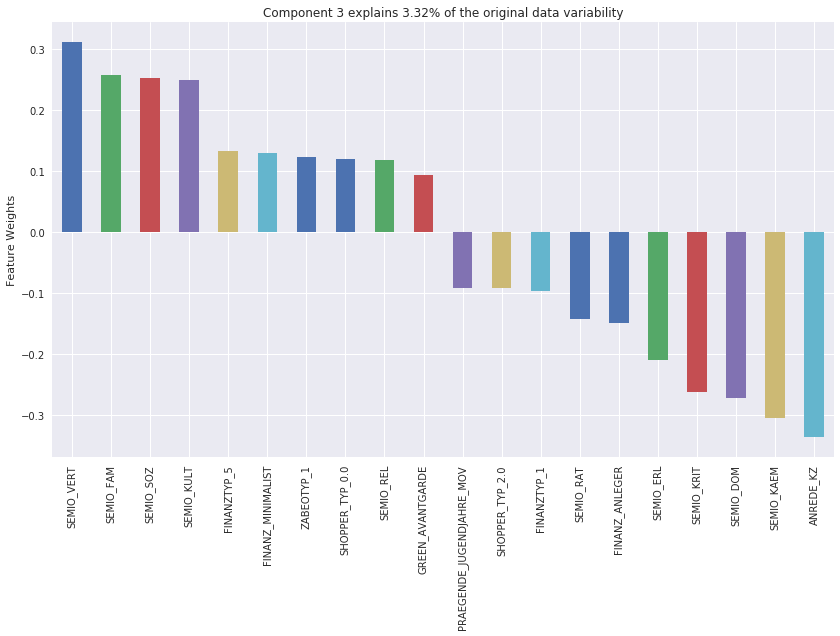

In [74]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_clean_data, pca, k_comp=3, top_k_weights=10)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

__Component 1__  
The first component seems to be more influenced by features related to characteristics of the area where people live in. Higher values of this component would represent areas with a larger population, lower income, poor neighborhoods, high percentage of people per household, close to the cities and point of sales, possibly more residential areas(1), and with a high movement pattern. Also, it seems that people living in these areas don't own a property and they are quite concerned about getting low interest rates. 

In summary, this component seems to represent __areas with poor/low-income, high-density population, close to city centre and close to shops.__

(1) The assumption under this component being more related to residential areas is because of a negative correlation with the feature PLZ8_GBZ - Number of buildings within the PLZ8 region. The higher the number of building the lower the value of this component becomes. This seems to contradict to some extent how other features weight on this component where the component increases for populated densed areas close to cities. So, I am not sure how to interpret the weight on this specific feature.

__Component 2__  
The second component is mainly influenced by personal features. Typically, this component would represent older people who like to be prepared. They are money savers although they may look into investment options. They are traditional people when it comes to buying and they don't seem to shop online and they are not crazy shoppers. They are rather lower or average income earners and mainly single. They are traditional, diutiful, religious and rational people.

In summary, this component seems to represent __traiditional and conservative people.__  

__Component 3__  
The third component is also influenced mainly by personal features. This component would represent male people with a rather combative attitude, dominant and critical minded. They are not religious, dreamful, family oriented, nor socially minded. They do care about investments. Generally speaking, they don't care that much about shopping although they do care about ecology and the environment. They are considered as avantgarde.

In summary, this component seems to represent __male, combative and dominant people.__  


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [75]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

# Below code is adapted from the lessons

def get_kmeans_scores(data, centers):
    scores = []
    
    for center in centers:
        #instantiate kmeans
        kmeans = MiniBatchKMeans(n_clusters=center)

        # Then fit the model to your data using the fit method
        model = kmeans.fit(data)

        # Obtain a score related to the model fit
        score = np.abs(model.score(data))        
        scores.append(score)
    
    return centers, scores

In [76]:
centers = list(range(1,36))
centers, scores = get_kmeans_scores(azdias_pca, centers)

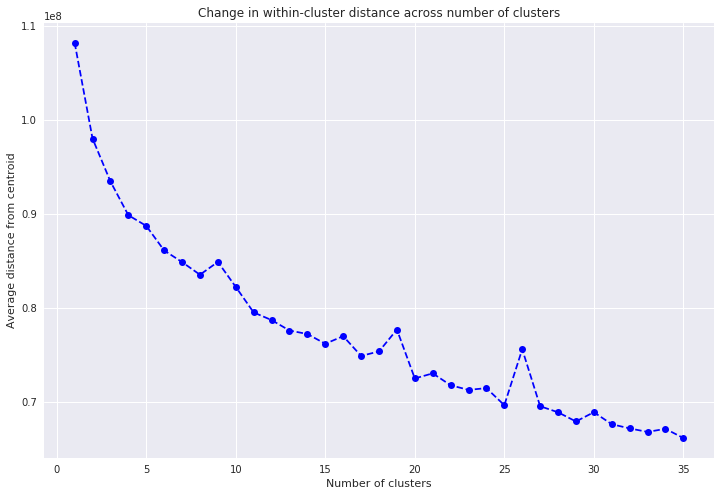

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12, 8))
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance from centroid')
plt.title('Change in within-cluster distance across number of clusters')
plt.show()

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 20
kmeans = KMeans(n_clusters=k)
azdias_kmeans = kmeans.fit_predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

After computing the average within-cluster distances, it seems that they start to level-off somewhere between 20-25 clusters.
I decided to continue the analysis with a total of 20 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [80]:
customers.shape

(191652, 85)

In [81]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply the clean_data function
customers_clean_data = clean_data(customers)

In [82]:
# Quick check to ensure that we have the same shape as the demographics dataset
customers_clean_data.shape

(141590, 209)

In [160]:
# Which columns are on the azdias subset which are missing on the customers dataset?
#azdias_clean_data.columns.difference(customers_clean_data.columns)

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [163]:
# Which columns are on the customers subset which are missing on the azdias dataset?
#customers_clean_data.columns.difference(azdias_clean_data.columns)

Index([], dtype='object')

In [162]:
# Note: It seems that on the customer dataset there were no records under the GEBAEUDETYP feature with a value of 5.
# This means that the get_dummies function will return one less feature on the customers_clean_data set
# when compared to the demographics data azdias_clean_data.

# Quick check to confirm above
#customers['GEBAEUDETYP'].loc[customers['GEBAEUDETYP']==5]

Series([], Name: GEBAEUDETYP, dtype: float64)

__Discussion Point:__  
The above discrepancy on the number of features, was solved by removing the dummy feature 'GEBAEUDETYP_5.0' from the azdias_clean_data dataframe. If I had not take care of this difference on the features on each dataset then I wouldn't have been able to apply the same scaler and PCA fitted models I derived from the azdias dataset into the customers dataset. So, I decided to go back, ammend the data_clean() function so that the dummy feature 'GEBAEUDETYP_5.0' is dropped from the azdias_clean_data dataframe and re-run all steps to get correct fitted models for the azdias dataset that I can apply to the customers dataset as well.

In [83]:
# Remove NaN with Imputer()
customers_clean_data = pd.DataFrame(imputer.transform(customers_clean_data), columns = customers_clean_data.columns)

In [84]:
# Quick check to confirm there are no missing values
customers_clean_data.isnull().values.any()

False

In [85]:
# Scale the customer data
customers_scaled_data = scaler.transform(customers_clean_data)

In [86]:
# Apply PCS on the customer data
customers_pca = pca.transform(customers_scaled_data)

In [87]:
# Identify clusters on the customer data
customers_kmeans = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [88]:
# Porportion of rows with few or no missing values per row (<20 NaN per row)
customers_lowna_row_per = len(customers_clean_data)/len(customers)
print('{:.2%}' .format(customers_lowna_row_per) + ' of the rows on the customers data have a few or no missing values.')

73.88% of the rows on the customers data have a few or no missing values.


In [90]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_clusters = pd.Series(azdias_kmeans)
azdias_clusters_count = azdias_clusters.value_counts().sort_index()
azdias_clusters_count = pd.Series(azdias_clusters_count)

In [91]:
azdias_clusters_count

0     36165
1     38743
2     54357
3     36063
4     35319
5     62128
6     45200
7     33413
8     33898
9     27148
10     8177
11    45059
12    43509
13    51456
14    37429
15    28891
16    27371
17    35232
18    63754
19    53765
dtype: int64

In [92]:
customers_clusters = pd.Series(customers_kmeans)
customers_clusters_count = customers_clusters.value_counts().sort_index()
customers_clusters_count = pd.Series(customers_clusters_count)

In [93]:
customers_clusters_count

0     14959
1      4481
2      7337
3       694
4      3957
5       754
6      7439
7     25891
8      7290
9       906
10     9222
11    17977
12      648
13      662
14    13283
15     2537
16     1470
17     6532
18     9839
19     5712
dtype: int64

In [94]:
clusters = pd.concat([azdias_clusters_count, customers_clusters_count], axis=1).reset_index()
clusters.columns = ['ClusterID', 'AzdiasCount', 'CustomersCount']
clusters

,ClusterID,AzdiasCount,CustomersCount
0,0,36165,14959
1,1,38743,4481
2,2,54357,7337
3,3,36063,694
4,4,35319,3957
5,5,62128,754
6,6,45200,7439
7,7,33413,25891
8,8,33898,7290
9,9,27148,906


In [95]:
clusters['AzdiasPercent'] = clusters['AzdiasCount'] / clusters['AzdiasCount'].sum()
clusters['CustomersPercent'] = clusters['CustomersCount'] / clusters['CustomersCount'].sum()
clusters['PercentDiff'] = clusters['CustomersPercent'] - clusters['AzdiasPercent']
clusters.sort_values('PercentDiff')

,ClusterID,AzdiasCount,CustomersCount,AzdiasPercent,CustomersPercent,PercentDiff
5,5,62128,754,0.077945,0.005325,-0.072620
13,13,51456,662,0.064556,0.004675,-0.059880
12,12,43509,648,0.054586,0.004577,-0.050009
3,3,36063,694,0.045244,0.004901,-0.040343
9,9,27148,906,0.034059,0.006399,-0.027661
19,19,53765,5712,0.067453,0.040342,-0.027111
16,16,27371,1470,0.034339,0.010382,-0.023957
15,15,28891,2537,0.036246,0.017918,-0.018328
1,1,38743,4481,0.048606,0.031648,-0.016959
2,2,54357,7337,0.068195,0.051819,-0.016377


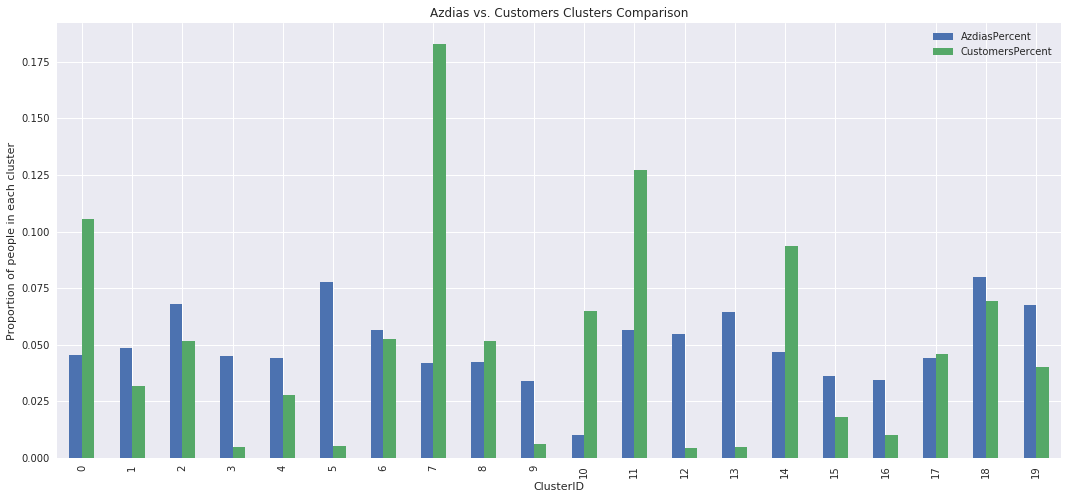

In [96]:
clusters.plot(x='ClusterID', y=['AzdiasPercent', 'CustomersPercent'], kind='bar', figsize=(18, 8))
plt.title('Azdias vs. Customers Clusters Comparison')
plt.ylabel('Proportion of people in each cluster')
plt.show()

In [97]:
# Get the original features values from the centroids of each clusters
clusters_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_clean_data.columns)

In [98]:
# Quick check to ensure I got the correct shape
clusters_specs.shape

(20, 209)

In [99]:
# Filter out only personal features to facilitate identifying what kind of people are part of a cluster

relevant_personal_features = [
'ALTERSKATEGORIE_GROB'
, 'ANREDE_KS'
, 'CJT_GESAMTTYP_1.0'
, 'CJT_GESAMTTYP_2.0'
, 'CJT_GESAMTTYP_3.0'
, 'CJT_GESAMTTYP_4.0'
, 'CJT_GESAMTTYP_5.0'
, 'CJT_GESAMTTYP_6.0'
, 'FINANZ_MINIMALIST'
, 'FINANZ_SPARER'
, 'FINANZ_VORSORGER'
, 'FINANZ_ANLEGER'
, 'FINANZ_UNAUFFAELLIGER'
, 'FINANZ_HAUSBAUER'
, 'GFK_URLAUBERTYP_1.0'
, 'GFK_URLAUBERTYP_2.0'
, 'GFK_URLAUBERTYP_3.0'
, 'GFK_URLAUBERTYP_4.0'
, 'GFK_URLAUBERTYP_5.0'
, 'GFK_URLAUBERTYP_6.0'
, 'GFK_URLAUBERTYP_7.0'
, 'GFK_URLAUBERTYP_8.0'
, 'GFK_URLAUBERTYP_9.0'
, 'GFK_URLAUBERTYP_10.0'
, 'GFK_URLAUBERTYP_11.0'
, 'GFK_URLAUBERTYP_12.0'
, 'GREEN_AVANTGARDE'
, 'LP_LEBENSPHASE_GROB_1.0'
, 'LP_LEBENSPHASE_GROB_2.0'
, 'LP_LEBENSPHASE_GROB_3.0'
, 'LP_LEBENSPHASE_GROB_4.0'
, 'LP_LEBENSPHASE_GROB_5.0'
, 'LP_LEBENSPHASE_GROB_6.0'
, 'LP_LEBENSPHASE_GROB_7.0'
, 'LP_LEBENSPHASE_GROB_8.0'
, 'LP_LEBENSPHASE_GROB_9.0'
, 'LP_LEBENSPHASE_GROB_10.0'
, 'LP_LEBENSPHASE_GROB_11.0'
, 'LP_LEBENSPHASE_GROB_12.0'
, 'LP_FAMILIE_GROB_1.0'
, 'LP_FAMILIE_GROB_2.0'
, 'LP_FAMILIE_GROB_3.0'
, 'LP_FAMILIE_GROB_4.0'
, 'LP_FAMILIE_GROB_5.0'
, 'PRAEGENDE_JUGENDJAHRE_GEN'
, 'PRAEGENDE_JUGENDJAHRE_MOV'
, 'RETOURTYP_BK_S'
, 'SEMIO_SOZ'
, 'SEMIO_FAM'
, 'SEMIO_REL'
, 'SEMIO_MAT'
, 'SEMIO_VERT'
, 'SEMIO_LUST'
, 'SEMIO_ERL'
, 'SEMIO_KULT'
, 'SEMIO_RAT'
, 'SEMIO_KRIT'
, 'SEMIO_DOM'
, 'SEMIO_KAEM'
, 'SEMIO_PFLICHT'
, 'SEMIO_TRADV'
, 'SHOPPER_TYP_0.0'
, 'SHOPPER_TYP_1.0'
, 'SHOPPER_TYP_2.0'
, 'SHOPPER_TYP_3.0'
, 'ZABEOTYP_1'
, 'ZABEOTYP_2'
, 'ZABEOTYP_3'
, 'ZABEOTYP_4'
, 'ZABEOTYP_5'
, 'ZABEOTYP_6' 
]

clusters_specs_reduced = clusters_specs.T
clusters_specs_reduced['attribute'] = clusters_specs_reduced.index
clusters_specs_reduced = clusters_specs_reduced[clusters_specs_reduced['attribute'].isin(relevant_personal_features)]

In [100]:
clusters_specs_reduced.shape

(70, 21)

In [101]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# I will extract original feature values for a selected group of personal features for cluster 7
pd.set_option('display.max_rows', 100)
clusters_specs_reduced[7]

ALTERSKATEGORIE_GROB          3.474589
FINANZ_MINIMALIST             4.647992
FINANZ_SPARER                 1.424247
FINANZ_VORSORGER              4.510579
FINANZ_ANLEGER                1.732151
FINANZ_UNAUFFAELLIGER         1.809068
FINANZ_HAUSBAUER              2.249000
GREEN_AVANTGARDE              0.990329
RETOURTYP_BK_S                3.652874
SEMIO_SOZ                     3.999788
SEMIO_FAM                     3.383163
SEMIO_REL                     2.902237
SEMIO_MAT                     3.153124
SEMIO_VERT                    4.808717
SEMIO_LUST                    5.473681
SEMIO_ERL                     5.374121
SEMIO_KULT                    3.524613
SEMIO_RAT                     3.104867
SEMIO_KRIT                    3.986379
SEMIO_DOM                     4.637825
SEMIO_KAEM                    4.273630
SEMIO_PFLICHT                 3.095426
SEMIO_TRADV                   2.911006
SHOPPER_TYP_0.0               0.137645
SHOPPER_TYP_1.0               0.283162
SHOPPER_TYP_2.0          

In [102]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# I will extract original feature values for a selected group of personal features for cluster 5
clusters_specs_reduced[5]

ALTERSKATEGORIE_GROB          1.793146
FINANZ_MINIMALIST             1.073745
FINANZ_SPARER                 4.513744
FINANZ_VORSORGER              2.235678
FINANZ_ANLEGER                4.455080
FINANZ_UNAUFFAELLIGER         3.953618
FINANZ_HAUSBAUER              4.254766
GREEN_AVANTGARDE              0.034243
RETOURTYP_BK_S                2.481596
SEMIO_SOZ                     3.140701
SEMIO_FAM                     3.877907
SEMIO_REL                     5.360292
SEMIO_MAT                     4.708273
SEMIO_VERT                    2.265279
SEMIO_LUST                    3.120952
SEMIO_ERL                     4.384296
SEMIO_KULT                    4.058866
SEMIO_RAT                     5.961379
SEMIO_KRIT                    5.448674
SEMIO_DOM                     6.073908
SEMIO_KAEM                    6.004211
SEMIO_PFLICHT                 6.076417
SEMIO_TRADV                   5.321521
SHOPPER_TYP_0.0               0.085546
SHOPPER_TYP_1.0               0.198215
SHOPPER_TYP_2.0          

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Firstly, I will make a comment about the subsets of data with a high proportion of missing values per row (>=20 NaN per row). If I compare the proportion of rows with high NaN values on both datasets, we have ~10.6% on the azdias dataset vs ~26% on the customer dataset. So, if we would consider those observations to be part of a new cluster as suggested on this project then we could argue that this cluster is overrepresented in the customer dataset. Actually, this would be a highly overrepresented cluster. However, there is not too much I can infere about this cluster unless I determine its centroid.

By looking at the remaining of the data, then based on the plot which compares the proportion of people under each cluster between the general population and the customers dataset it seems that clusters 7, 11, 0, 10 and 14 are overrepresenting customers so the people in these clusters could be a target audience for the company. On the other hand, it seems that clusters 5, 13, 12 and 3 are underrepresented and suggests that these groups of persons are outside of the target demographics.

If we look in more detail at cluster 7 then this cluster could represent rather older, rational, traditional and dutiful people who are part of the avantgarde movement and are also familiy minded. They seem to be high income earners and mony savers interested in investing. They are also home owners who don't care that much about low financial interest - probably because they don't have a mortgage to pay :).  

If we look in more detail at cluster 5 then this cluster could represent rather middle age or younger people who are mainly single and belong to the mainstream movement. They are rather low or average income earners who are price-driven and they tend to be demanding heavy-returnes. The would typically don't own a home and they would be paying attention on low financial interest.

Before making any final recommendation on what features or clusters could be identified with potential customers, ideally I would review the overrepresented clusters (7, 11, 0, 10 and 14) in more detail to see similarities and differences on all the features values of its centroids.